In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_DIR = Path('../data')
RAW_DIR = DATA_DIR / 'raw'
CLEANED_DIR = DATA_DIR / 'cleaned'
CLEANED_DIR.mkdir(parents=True, exist_ok=True)

# Outlier detection threshold
OUTLIER_STD = 3  # Number of standard deviations

In [3]:
# ============================================================================
# LOAD RAW DATA
# ============================================================================

print("="*70)
print("LOADING RAW DATA")
print("="*70)

spot_df = pd.read_csv(RAW_DIR / 'nifty_spot_5min.csv')
futures_df = pd.read_csv(RAW_DIR / 'nifty_futures_5min.csv')
options_df = pd.read_csv(RAW_DIR / 'nifty_options_5min.csv')

# Convert timestamp columns
spot_df['timestamp'] = pd.to_datetime(spot_df['timestamp'])
futures_df['timestamp'] = pd.to_datetime(futures_df['timestamp'])
options_df['timestamp'] = pd.to_datetime(options_df['timestamp'])

print(f"\n✓ Loaded Spot Data: {spot_df.shape}")
print(f"✓ Loaded Futures Data: {futures_df.shape}")
print(f"✓ Loaded Options Data: {options_df.shape}")

LOADING RAW DATA

✓ Loaded Spot Data: (28880, 6)
✓ Loaded Futures Data: (28880, 8)
✓ Loaded Options Data: (288800, 8)


In [4]:
# ============================================================================
# DATA QUALITY CHECKS
# ============================================================================

print("\n" + "="*70)
print("DATA QUALITY CHECKS")
print("="*70)

def check_data_quality(df, name):
    """Comprehensive data quality check"""
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"  Missing Values:\n{df.isnull().sum()}")
    print(f"  Duplicate Rows: {df.duplicated().sum()}")
    
    # Check for anomalies in OHLC
    if all(col in df.columns for col in ['open', 'high', 'low', 'close']):
        invalid_ohlc = (
            (df['high'] < df['low']) |
            (df['high'] < df['open']) |
            (df['high'] < df['close']) |
            (df['low'] > df['open']) |
            (df['low'] > df['close'])
        ).sum()
        print(f"  Invalid OHLC: {invalid_ohlc}")
    
    return df

spot_df = check_data_quality(spot_df, "SPOT DATA")
futures_df = check_data_quality(futures_df, "FUTURES DATA")
options_df = check_data_quality(options_df, "OPTIONS DATA")



DATA QUALITY CHECKS

SPOT DATA:
  Shape: (28880, 6)
  Date Range: 2024-01-01 09:15:00 to 2025-01-14 15:30:00
  Missing Values:
timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64
  Duplicate Rows: 0
  Invalid OHLC: 0

FUTURES DATA:
  Shape: (28880, 8)
  Date Range: 2024-01-01 09:15:00 to 2025-01-14 15:30:00
  Missing Values:
timestamp        0
open             0
high             0
low              0
close            0
volume           0
open_interest    0
expiry           0
dtype: int64
  Duplicate Rows: 0
  Invalid OHLC: 0

OPTIONS DATA:
  Shape: (288800, 8)
  Date Range: 2024-01-01 09:15:00 to 2025-01-14 15:30:00
  Missing Values:
timestamp              0
strike                 0
option_type            0
ltp                37240
iv                     0
open_interest          0
volume                 0
strike_position        0
dtype: int64
  Duplicate Rows: 0


In [5]:
# ============================================================================
# STEP 1: HANDLE MISSING VALUES
# ============================================================================

print("\n" + "="*70)
print("STEP 1: HANDLING MISSING VALUES")
print("="*70)

def handle_missing_values(df, method='ffill'):
    """
    Handle missing values
    Methods: 'ffill' (forward fill), 'bfill' (backward fill), 'interpolate'
    """
    original_missing = df.isnull().sum().sum()
    
    # Forward fill for time series continuity
    df = df.fillna(method='ffill')
    
    # Backward fill for remaining NaN at start
    df = df.fillna(method='bfill')
    
    # If still NaN, use interpolation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
    
    final_missing = df.isnull().sum().sum()
    
    print(f"  Original missing values: {original_missing}")
    print(f"  Remaining missing values: {final_missing}")
    
    return df

spot_df = handle_missing_values(spot_df)
futures_df = handle_missing_values(futures_df)
options_df = handle_missing_values(options_df)



STEP 1: HANDLING MISSING VALUES
  Original missing values: 0
  Remaining missing values: 0
  Original missing values: 0
  Remaining missing values: 0
  Original missing values: 37240
  Remaining missing values: 0


In [6]:
# ============================================================================
# STEP 2: REMOVE DUPLICATES
# ============================================================================

print("\n" + "="*70)
print("STEP 2: REMOVING DUPLICATES")
print("="*70)

def remove_duplicates(df):
    """Remove duplicate timestamps"""
    original_len = len(df)
    df = df.drop_duplicates(subset=['timestamp'], keep='first')
    removed = original_len - len(df)
    print(f"  Removed {removed} duplicate rows")
    return df

spot_df = remove_duplicates(spot_df)
futures_df = remove_duplicates(futures_df)

# For options, keep timestamp + strike + option_type unique
original_len = len(options_df)
options_df = options_df.drop_duplicates(
    subset=['timestamp', 'strike', 'option_type'], 
    keep='first'
)
print(f"  Options: Removed {original_len - len(options_df)} duplicate rows")



STEP 2: REMOVING DUPLICATES
  Removed 0 duplicate rows
  Removed 0 duplicate rows
  Options: Removed 0 duplicate rows


In [7]:
# ============================================================================
# STEP 3: REMOVE OUTLIERS
# ============================================================================

print("\n" + "="*70)
print("STEP 3: REMOVING OUTLIERS")
print("="*70)

def detect_outliers_zscore(df, columns, threshold=3):
    """Detect outliers using Z-score method"""
    outliers_mask = pd.Series([False] * len(df))
    
    for col in columns:
        if col in df.columns:
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            outliers_mask |= (z_scores > threshold)
    
    return outliers_mask

def remove_outliers(df, columns, threshold=OUTLIER_STD):
    """Remove outliers based on Z-score"""
    original_len = len(df)
    
    outliers_mask = detect_outliers_zscore(df, columns, threshold)
    df_clean = df[~outliers_mask].copy()
    
    removed = original_len - len(df_clean)
    print(f"  Removed {removed} outlier rows ({removed/original_len*100:.2f}%)")
    
    return df_clean

# Remove outliers from price columns
spot_df = remove_outliers(
    spot_df, 
    ['open', 'high', 'low', 'close', 'volume']
)

futures_df = remove_outliers(
    futures_df,
    ['open', 'high', 'low', 'close', 'volume', 'open_interest']
)

options_df = remove_outliers(
    options_df,
    ['ltp', 'iv', 'open_interest', 'volume']
)


STEP 3: REMOVING OUTLIERS
  Removed 0 outlier rows (0.00%)
  Removed 0 outlier rows (0.00%)
  Removed 1267 outlier rows (0.44%)


In [8]:
# ============================================================================
# STEP 4: VALIDATE OHLC RELATIONSHIPS
# ============================================================================

print("\n" + "="*70)
print("STEP 4: VALIDATING OHLC RELATIONSHIPS")
print("="*70)

def validate_ohlc(df):
    """Ensure High >= Low, Open, Close and Low <= Open, Close"""
    original_len = len(df)
    
    # Remove rows where OHLC relationships are invalid
    valid_mask = (
        (df['high'] >= df['low']) &
        (df['high'] >= df['open']) &
        (df['high'] >= df['close']) &
        (df['low'] <= df['open']) &
        (df['low'] <= df['close'])
    )
    
    df_valid = df[valid_mask].copy()
    removed = original_len - len(df_valid)
    
    print(f"  Removed {removed} rows with invalid OHLC")
    
    return df_valid

spot_df = validate_ohlc(spot_df)
futures_df = validate_ohlc(futures_df)



STEP 4: VALIDATING OHLC RELATIONSHIPS
  Removed 0 rows with invalid OHLC
  Removed 0 rows with invalid OHLC


In [9]:
# ============================================================================
# STEP 5: ALIGN TIMESTAMPS
# ============================================================================

print("\n" + "="*70)
print("STEP 5: ALIGNING TIMESTAMPS")
print("="*70)

def align_timestamps(*dfs):
    """Find common timestamps across all dataframes"""
    # Get intersection of all timestamps
    common_timestamps = set(dfs[0]['timestamp'])
    
    for df in dfs[1:]:
        common_timestamps &= set(df['timestamp'])
    
    print(f"  Common timestamps: {len(common_timestamps)}")
    
    # Filter each dataframe
    aligned_dfs = []
    for df in dfs:
        aligned = df[df['timestamp'].isin(common_timestamps)].copy()
        aligned = aligned.sort_values('timestamp').reset_index(drop=True)
        aligned_dfs.append(aligned)
    
    return aligned_dfs

spot_df, futures_df, options_df = align_timestamps(
    spot_df, futures_df, options_df
)

print(f"  Spot: {len(spot_df)} rows")
print(f"  Futures: {len(futures_df)} rows")
print(f"  Options: {len(options_df)} rows")



STEP 5: ALIGNING TIMESTAMPS
  Common timestamps: 28880
  Spot: 28880 rows
  Futures: 28880 rows
  Options: 287533 rows


In [10]:
# ============================================================================
# STEP 6: HANDLE FUTURES ROLLOVER
# ============================================================================

print("\n" + "="*70)
print("STEP 6: HANDLING FUTURES ROLLOVER")
print("="*70)

def create_continuous_futures(df):
    """
    Create continuous futures contract by rolling over at expiry
    Roll 3 days before expiry to avoid illiquidity
    """
    df = df.copy()
    df['expiry'] = pd.to_datetime(df['expiry'])
    
    # Calculate days to expiry
    df['days_to_expiry'] = (df['expiry'] - df['timestamp']).dt.days
    
    # Identify rollover points (3 days before expiry)
    df['roll_signal'] = df['days_to_expiry'] <= 3
    
    # Track contract changes
    df['contract_number'] = (df['roll_signal'].shift(1).fillna(False)).cumsum()
    
    # Calculate adjustment factor for price continuity
    adjustments = []
    contracts = df['contract_number'].unique()
    
    for i in range(len(contracts) - 1):
        curr_contract = contracts[i]
        next_contract = contracts[i + 1]
        
        # Last price of current contract
        curr_last = df[df['contract_number'] == curr_contract]['close'].iloc[-1]
        
        # First price of next contract
        next_first = df[df['contract_number'] == next_contract]['close'].iloc[0]
        
        # Adjustment factor
        adjustment = curr_last - next_first
        adjustments.append(adjustment)
    
    # Apply adjustments to create continuous series
    cumulative_adjustment = 0
    df['adjusted_close'] = df['close'].copy()
    
    for i, contract in enumerate(contracts[1:], 1):
        cumulative_adjustment += adjustments[i-1]
        mask = df['contract_number'] == contract
        df.loc[mask, 'adjusted_close'] += cumulative_adjustment
    
    rollover_count = len(adjustments)
    print(f"  Detected {rollover_count} futures rollovers")
    print(f"  Created continuous contract with adjusted prices")
    
    return df

if 'expiry' in futures_df.columns:
    futures_df = create_continuous_futures(futures_df)
else:
    print("  No expiry column found, skipping rollover adjustment")



STEP 6: HANDLING FUTURES ROLLOVER
  Detected 7372 futures rollovers
  Created continuous contract with adjusted prices


In [11]:
# ============================================================================
# STEP 7: CALCULATE ATM STRIKE DYNAMICALLY
# ============================================================================

print("\n" + "="*70)
print("STEP 7: CALCULATING ATM STRIKE DYNAMICALLY")
print("="*70)

def calculate_atm_strike(spot_price, strike_interval=50):
    """Calculate nearest ATM strike"""
    return round(spot_price / strike_interval) * strike_interval

# Add ATM strike for each timestamp in spot data
spot_df['atm_strike'] = spot_df['close'].apply(
    lambda x: calculate_atm_strike(x)
)

print(f"  ATM strike range: {spot_df['atm_strike'].min()} to {spot_df['atm_strike'].max()}")

# Tag options as ATM, ATM+1, ATM-1, etc.
def tag_option_position(row, spot_df):
    """Tag option strike position relative to ATM"""
    timestamp = row['timestamp']
    strike = row['strike']
    
    # Find corresponding spot price
    spot_row = spot_df[spot_df['timestamp'] == timestamp]
    
    if len(spot_row) > 0:
        atm = spot_row['atm_strike'].iloc[0]
        position = int((strike - atm) / 50)
        return position
    return None

options_df['strike_position'] = options_df.apply(
    lambda row: tag_option_position(row, spot_df), 
    axis=1
)

print(f"  Tagged options by strike position")
print(f"  Strike positions: {options_df['strike_position'].unique()}")


STEP 7: CALCULATING ATM STRIKE DYNAMICALLY
  ATM strike range: 14150 to 197150
  Tagged options by strike position
  Strike positions: [-2 -1  0  1  2]


In [12]:
# ============================================================================
# STEP 8: FILTER OPTIONS DATA (ATM ±2 ONLY)
# ============================================================================

print("\n" + "="*70)
print("STEP 8: FILTERING OPTIONS (ATM ±2)")
print("="*70)

options_df = options_df[
    options_df['strike_position'].between(-2, 2)
].copy()

print(f"  Filtered options: {len(options_df)} rows")
print(f"  Unique strikes per timestamp: {options_df.groupby('timestamp')['strike'].nunique().mean():.1f}")



STEP 8: FILTERING OPTIONS (ATM ±2)
  Filtered options: 287533 rows
  Unique strikes per timestamp: 5.0


In [13]:
# ============================================================================
# SAVE CLEANED DATA
# ============================================================================

print("\n" + "="*70)
print("SAVING CLEANED DATA")
print("="*70)

spot_clean_file = CLEANED_DIR / 'nifty_spot_5min_clean.csv'
futures_clean_file = CLEANED_DIR / 'nifty_futures_5min_clean.csv'
options_clean_file = CLEANED_DIR / 'nifty_options_5min_clean.csv'

spot_df.to_csv(spot_clean_file, index=False)
futures_df.to_csv(futures_clean_file, index=False)
options_df.to_csv(options_clean_file, index=False)

print(f"\n✓ Saved: {spot_clean_file}")
print(f"✓ Saved: {futures_clean_file}")
print(f"✓ Saved: {options_clean_file}")


SAVING CLEANED DATA

✓ Saved: ..\data\cleaned\nifty_spot_5min_clean.csv
✓ Saved: ..\data\cleaned\nifty_futures_5min_clean.csv
✓ Saved: ..\data\cleaned\nifty_options_5min_clean.csv


In [14]:
# ============================================================================
# GENERATE CLEANING REPORT
# ============================================================================

print("\n" + "="*70)
print("GENERATING CLEANING REPORT")
print("="*70)

report = f"""DATA CLEANING REPORT
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*70}

ORIGINAL DATA
-------------
Spot Records: {pd.read_csv(RAW_DIR / 'nifty_spot_5min.csv').shape[0]:,}
Futures Records: {pd.read_csv(RAW_DIR / 'nifty_futures_5min.csv').shape[0]:,}
Options Records: {pd.read_csv(RAW_DIR / 'nifty_options_5min.csv').shape[0]:,}

CLEANED DATA
------------
Spot Records: {len(spot_df):,}
Futures Records: {len(futures_df):,}
Options Records: {len(options_df):,}

CLEANING OPERATIONS
-------------------
1. Missing Values: Handled using forward fill + backward fill + interpolation
2. Duplicates: Removed based on timestamp uniqueness
3. Outliers: Removed using Z-score method (threshold = {OUTLIER_STD})
4. OHLC Validation: Ensured High >= Low, Open, Close
5. Timestamp Alignment: Aligned all datasets to common timestamps
6. Futures Rollover: Created continuous contract with price adjustments
7. ATM Strike: Calculated dynamically for each timestamp
8. Options Filter: Kept only ATM ±2 strikes

DATA QUALITY METRICS
--------------------
Spot Data:
  - Date Range: {spot_df['timestamp'].min()} to {spot_df['timestamp'].max()}
  - Missing Values: {spot_df.isnull().sum().sum()}
  - Price Range: {spot_df['close'].min():.2f} to {spot_df['close'].max():.2f}

Futures Data:
  - Date Range: {futures_df['timestamp'].min()} to {futures_df['timestamp'].max()}
  - Missing Values: {futures_df.isnull().sum().sum()}
  - Price Range: {futures_df['close'].min():.2f} to {futures_df['close'].max():.2f}

Options Data:
  - Date Range: {options_df['timestamp'].min()} to {options_df['timestamp'].max()}
  - Missing Values: {options_df.isnull().sum().sum()}
  - Unique Strikes: {options_df['strike'].nunique()}
  - Options per Timestamp: {options_df.groupby('timestamp').size().mean():.1f}

NEXT STEPS
----------
1. Merge cleaned datasets
2. Engineer features
3. Calculate Greeks
"""

report_file = CLEANED_DIR / 'data_cleaning_report.txt'
with open(report_file, 'w') as f:
    f.write(report)

print(report)
print(f"\n✓ Saved: {report_file}")


GENERATING CLEANING REPORT
DATA CLEANING REPORT
Generated: 2026-01-16 15:36:31

ORIGINAL DATA
-------------
Spot Records: 28,880
Futures Records: 28,880
Options Records: 288,800

CLEANED DATA
------------
Spot Records: 28,880
Futures Records: 28,880
Options Records: 287,533

CLEANING OPERATIONS
-------------------
1. Missing Values: Handled using forward fill + backward fill + interpolation
2. Duplicates: Removed based on timestamp uniqueness
3. Outliers: Removed using Z-score method (threshold = 3)
4. OHLC Validation: Ensured High >= Low, Open, Close
5. Timestamp Alignment: Aligned all datasets to common timestamps
6. Futures Rollover: Created continuous contract with price adjustments
7. ATM Strike: Calculated dynamically for each timestamp
8. Options Filter: Kept only ATM ±2 strikes

DATA QUALITY METRICS
--------------------
Spot Data:
  - Date Range: 2024-01-01 09:15:00 to 2025-01-14 15:30:00
  - Missing Values: 0
  - Price Range: 14149.25 to 197140.72

Futures Data:
  - Date Rang


CREATING VISUALIZATIONS
✓ Saved: cleaning_visualizations.png


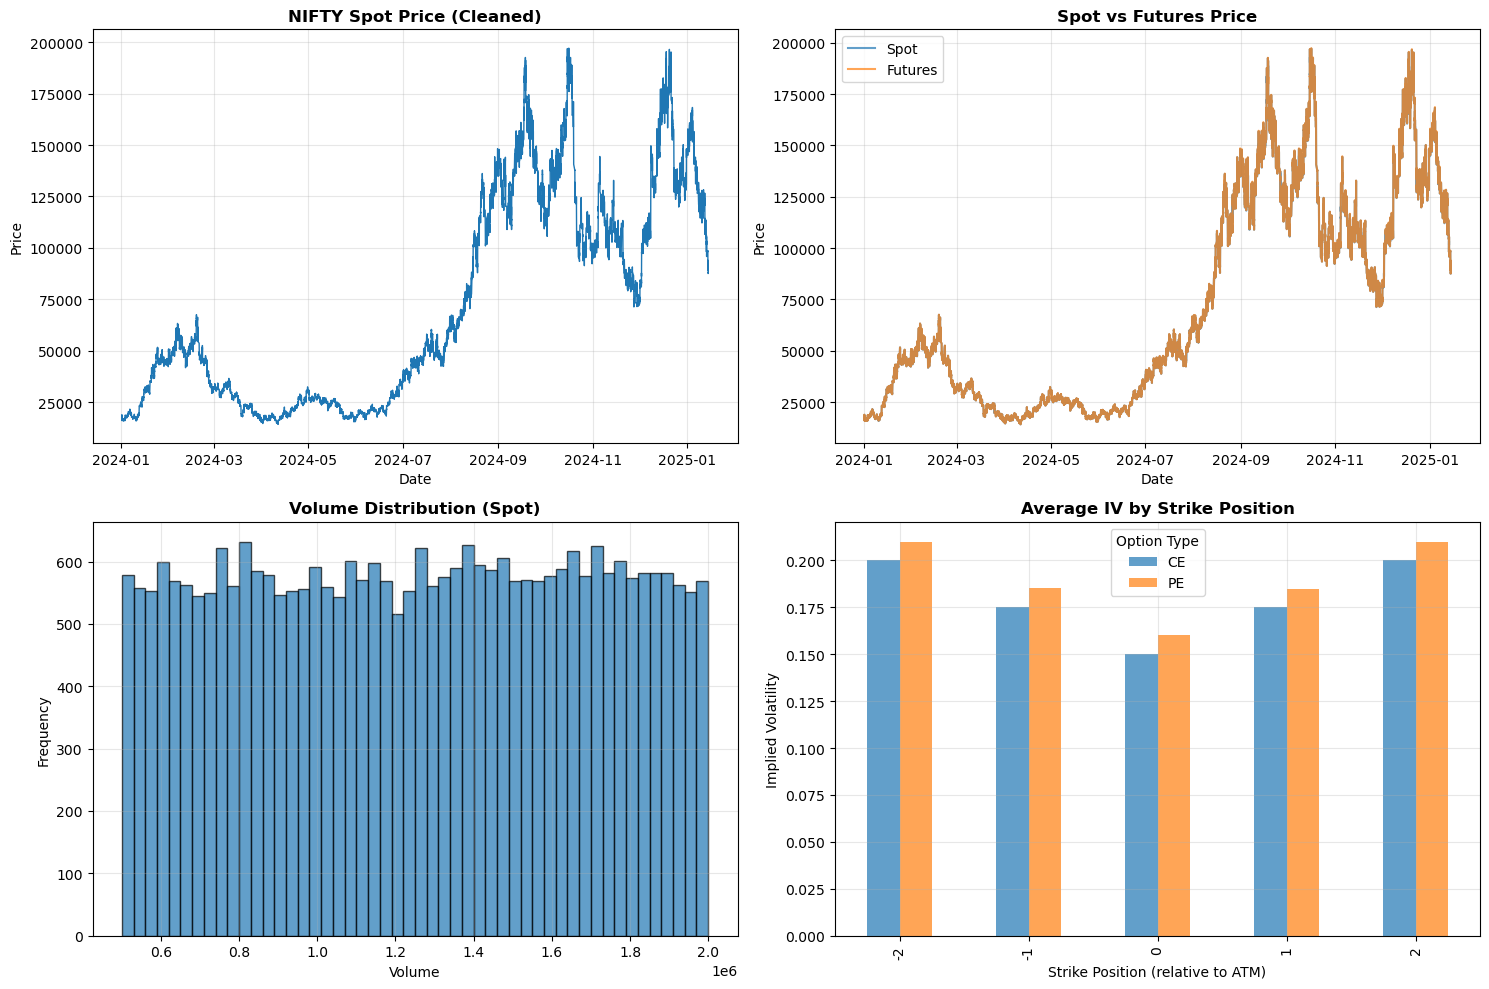

In [15]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Spot Price
axes[0, 0].plot(spot_df['timestamp'], spot_df['close'], linewidth=1)
axes[0, 0].set_title('NIFTY Spot Price (Cleaned)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')
axes[0, 0].grid(True, alpha=0.3)

# 2. Futures vs Spot
axes[0, 1].plot(spot_df['timestamp'], spot_df['close'], label='Spot', alpha=0.7)
axes[0, 1].plot(futures_df['timestamp'], futures_df['close'], label='Futures', alpha=0.7)
axes[0, 1].set_title('Spot vs Futures Price', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Volume Distribution
axes[1, 0].hist(spot_df['volume'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Volume Distribution (Spot)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Volume')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. Options IV by Strike Position
iv_by_position = options_df.groupby(['strike_position', 'option_type'])['iv'].mean().unstack()
iv_by_position.plot(kind='bar', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_title('Average IV by Strike Position', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Strike Position (relative to ATM)')
axes[1, 1].set_ylabel('Implied Volatility')
axes[1, 1].legend(title='Option Type')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(CLEANED_DIR / 'cleaning_visualizations.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: cleaning_visualizations.png")
plt.show()


In [17]:
# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*70)
print("DATA CLEANING COMPLETE")
print("="*70)



DATA CLEANING COMPLETE
